In [1]:
import os
import gc
import sys
import torch
import scipy
import psutil
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models, set_image_backend

import data_utils
import train_utils
import model_utils

%reload_ext autoreload
%autoreload 2

set_image_backend('accimage')

In [2]:
# setup
set_image_backend('accimage')
device = torch.device('cuda', 1)

# load sample annotations pickle
pickle_file = '/home/sxchao/MSI_prediction/tcga_project/tcga_wgd_sa_all.pkl'
batch_all, _, _, sa_trains, sa_vals = data_utils.load_COAD_train_val_sa_pickle(pickle_file=pickle_file,
                                                                               return_all_cancers=True, 
                                                                               split_in_two=True)
# normalize and tensorify jpegs
val_transform = train_utils.transform_validation

# initialize Datasets
val_sets = []
val_cancers = ['UCEC', 'LIHC_10x', 'KIRC_10x']
magnification = '10.0'
root_dir = '/n/mounted-data-drive/'
for j in range(len(val_cancers)):
    val_set = data_utils.TCGADataset_tiles(sa_trains[batch_all.index(val_cancers[j])], 
                                           root_dir + val_cancers[j] + '/', 
                                           transform=val_transform, 
                                           magnification=magnification, 
                                           batch_type='tile', 
                                           return_jpg_to_sample=True)
    val_sets.append(val_set)

# get DataLoaders    
batch_size_val = 400
n_workers = 16
val_loaders = [torch.utils.data.DataLoader(val_set, batch_size=batch_size_val, shuffle=True, 
                                           num_workers=n_workers, pin_memory=True) for val_set in val_sets]

In [3]:
# model args
state_dict_file_resnet = '/n/tcga_models/resnet18_WGD_all_10x.pt'
state_dict_file_maml = '/n/tcga_models/maml_WGD_10x_v02a.pt'
input_size = 2048
hidden_size = 512
output_size = 1

# initialize trained resnet
resnet = models.resnet18(pretrained=False)
resnet.fc = nn.Linear(2048, output_size, bias=True)
saved_state = torch.load(state_dict_file_resnet, map_location=lambda storage, loc: storage)
resnet.load_state_dict(saved_state)

# freeze layers
resnet.fc = model_utils.Identity()
resnet.cuda(device=device)
for param in resnet.parameters():
    param.requires_grad = False
resnet.eval()

# initialize theta_global
net = model_utils.FeedForward(input_size, hidden_size, output_size)
saved_state = torch.load(state_dict_file_maml, map_location=lambda storage, loc: storage)
net.load_state_dict(saved_state)
net.cuda(device=device)
theta_global = [p.detach().clone() for p in net.parameters()]

In [4]:
num_steps = 5
all_logits = {}
for i in range(num_steps):
    all_logits[i] = []
all_labels = []
all_types = []
all_jpgs = []

In [5]:
alpha = 1e-2
criterion_mean = nn.BCEWithLogitsLoss()
criterion_none = nn.BCEWithLogitsLoss(reduction = 'none')
optimizer = torch.optim.Adam(net.parameters(), lr = alpha)

In [ ]:
cancer_num = 1
print(len(val_loaders[cancer_num]), 'batches to go')
for batch_num,(tiles,labels,jpg_to_sample) in enumerate(val_loaders[cancer_num]):
    if batch_num % 100 == 0:
        print(batch_num, end=' ')    
    tiles, labels = tiles.cuda(device=device), labels.cuda(device=device).float()
    idx = int(tiles.shape[0] / 2)
    inputs_a = tiles[:idx,:,:,:]
    inputs_b = tiles[idx:,:,:,:]
    labels_a = labels[:idx].unsqueeze(1)
    labels_b = labels[idx:].unsqueeze(1)    
    labels = labels_b.contiguous().view(-1).detach().cpu().numpy()
    jpg_to_sample = jpg_to_sample[idx:].view(-1).float().numpy()
    all_labels.extend(labels)
    all_types.extend([cancer_num] * round(tiles.shape[0] / 2)) # last batch may have odd number of tiles
    all_jpgs.extend(jpg_to_sample)
    
    for step in range(num_steps): 
        optimizer.zero_grad()
        if step == 0:
            net.eval()                
            output_b = net(resnet(inputs_b))
            logits = output_b.contiguous().view(-1).float().detach().cpu().numpy()
            all_logits[step].extend(logits)
        else:
            # first forward pass, step 
            net.train()
            output_a = net(resnet(inputs_a))
            loss = criterion_mean(output_a, labels_a)
            loss.backward()
            optimizer.step()            
            # second forward pass   
            net.eval()
            output_b = net(resnet(inputs_b))
            logits = output_b.contiguous().view(-1).float().detach().cpu().numpy()
            all_logits[step].extend(logits)
    net.update_params(theta_global)

In [42]:
d = {'label': all_labels, 'logit': all_logits[3], 'type': all_types, 'sample': all_jpgs}
df = pd.DataFrame(data = d)
df2 = df.groupby(['type','sample'])['label','logit'].mean()
loss = criterion_none(torch.tensor(df2['logit'].values, device=device), torch.tensor(df2['label'].values, device=device))
torch.std(loss), torch.mean(loss), torch.median(loss)

(tensor(9.7769, device='cuda:1', dtype=torch.float64),
 tensor(4.5683, device='cuda:1', dtype=torch.float64),
 tensor(0., device='cuda:1', dtype=torch.float64))

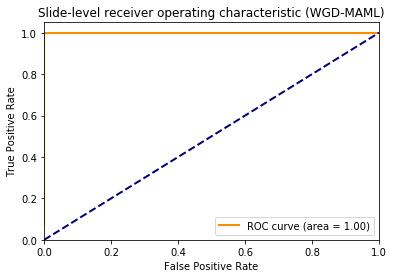

In [43]:
fpr, tpr, thresholds = metrics.roc_curve(np.array(df2['label']), scipy.special.expit(np.array(df2['logit'])))
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Slide-level receiver operating characteristic (WGD-MAML)')
plt.legend(loc="lower right")
plt.show()

In [10]:
all_std = []
all_mean = []
all_med = []
all_auc = []
for i in range(num_steps):
    d = {'label': all_labels, 'logit': all_logits[i], 'type': all_types, 'sample': all_jpgs}
    df = pd.DataFrame(data = d)
    df2 = df.groupby(['type','sample'])['label','logit'].mean()
    
    loss = criterion_none(torch.tensor(df2['logit'].values, device=device), torch.tensor(df2['label'].values, device=device))
    all_std.append(torch.std(loss).item()), all_mean.append(torch.mean(loss).item()), all_med.append(torch.median(loss).item())
    
    fpr, tpr, thresholds = metrics.roc_curve(np.array(df2['label']), scipy.special.expit(np.array(df2['logit'])))
    roc_auc = metrics.auc(fpr, tpr)
    all_auc.append(roc_auc)

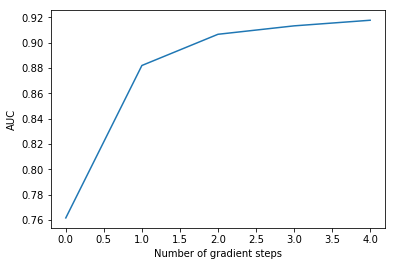

In [8]:
plt.plot(np.arange(num_steps),all_auc)
plt.xlabel('Number of gradient steps')
plt.ylabel('AUC')
plt.show()

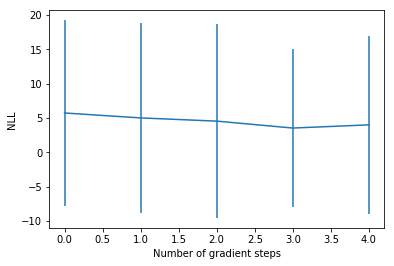

In [12]:
plt.errorbar(np.arange(num_steps), all_mean, all_std)
plt.xlabel('Number of gradient steps')
plt.ylabel('NLL')
plt.show()

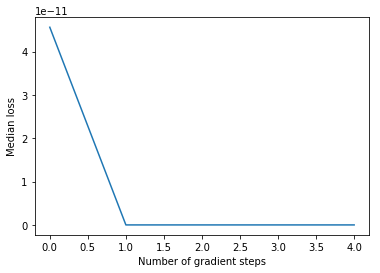

In [11]:
plt.plot(np.arange(num_steps),all_med)
plt.xlabel('Number of gradient steps')
plt.ylabel('Median loss')
plt.show()